In [109]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [110]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [113]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  6,  0,  1,  8,  5,  4,  7, 10]), tensor([9, 2]))

In [114]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [115]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[5.5859],
        [5.3874]], grad_fn=<AddmmBackward>)

In [116]:
linear_model.weight

Parameter containing:
tensor([[0.9020]], requires_grad=True)

In [117]:
linear_model.bias

Parameter containing:
tensor([0.1379], requires_grad=True)

In [118]:
x = torch.ones(1)
linear_model(x)

tensor([1.0399], grad_fn=<AddBackward0>)

In [119]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399],
        [1.0399]], grad_fn=<AddmmBackward>)

In [120]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [121]:
linear_model.parameters()

<generator object Module.parameters at 0x7fea996a31d0>

In [122]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.0585]], requires_grad=True),
 Parameter containing:
 tensor([-0.6850], requires_grad=True)]

In [123]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [124]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 275.7834, Validation loss 312.3641
Epoch 1000, Training loss 3.4860, Validation loss 2.7066
Epoch 2000, Training loss 2.9428, Validation loss 2.9771
Epoch 3000, Training loss 2.9341, Validation loss 3.0137

Parameter containing:
tensor([[5.4100]], requires_grad=True)
Parameter containing:
tensor([-17.3959], requires_grad=True)


In [125]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 286.2015, Validation loss 323.5591
Epoch 1000, Training loss 3.5325, Validation loss 2.6946
Epoch 2000, Training loss 2.9436, Validation loss 2.9753
Epoch 3000, Training loss 2.9341, Validation loss 3.0135

Parameter containing:
tensor([[5.4097]], requires_grad=True)
Parameter containing:
tensor([-17.3944], requires_grad=True)


In [126]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [127]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [128]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [129]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [130]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0173], requires_grad=True)

In [131]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 175.0928, Validation loss 182.7539
Epoch 1000, Training loss 4.7101, Validation loss 3.6624
Epoch 2000, Training loss 2.4978, Validation loss 3.0216
Epoch 3000, Training loss 1.6385, Validation loss 3.6785
Epoch 4000, Training loss 1.4771, Validation loss 3.5279
Epoch 5000, Training loss 1.4157, Validation loss 3.5605
output tensor([[15.3339],
        [13.7061]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [15.]])
hidden tensor([[-0.0497],
        [-0.0193],
        [ 0.0036],
        [ 0.0291],
        [ 0.0167],
        [-0.0927],
        [-0.0021],
        [ 0.0174]])


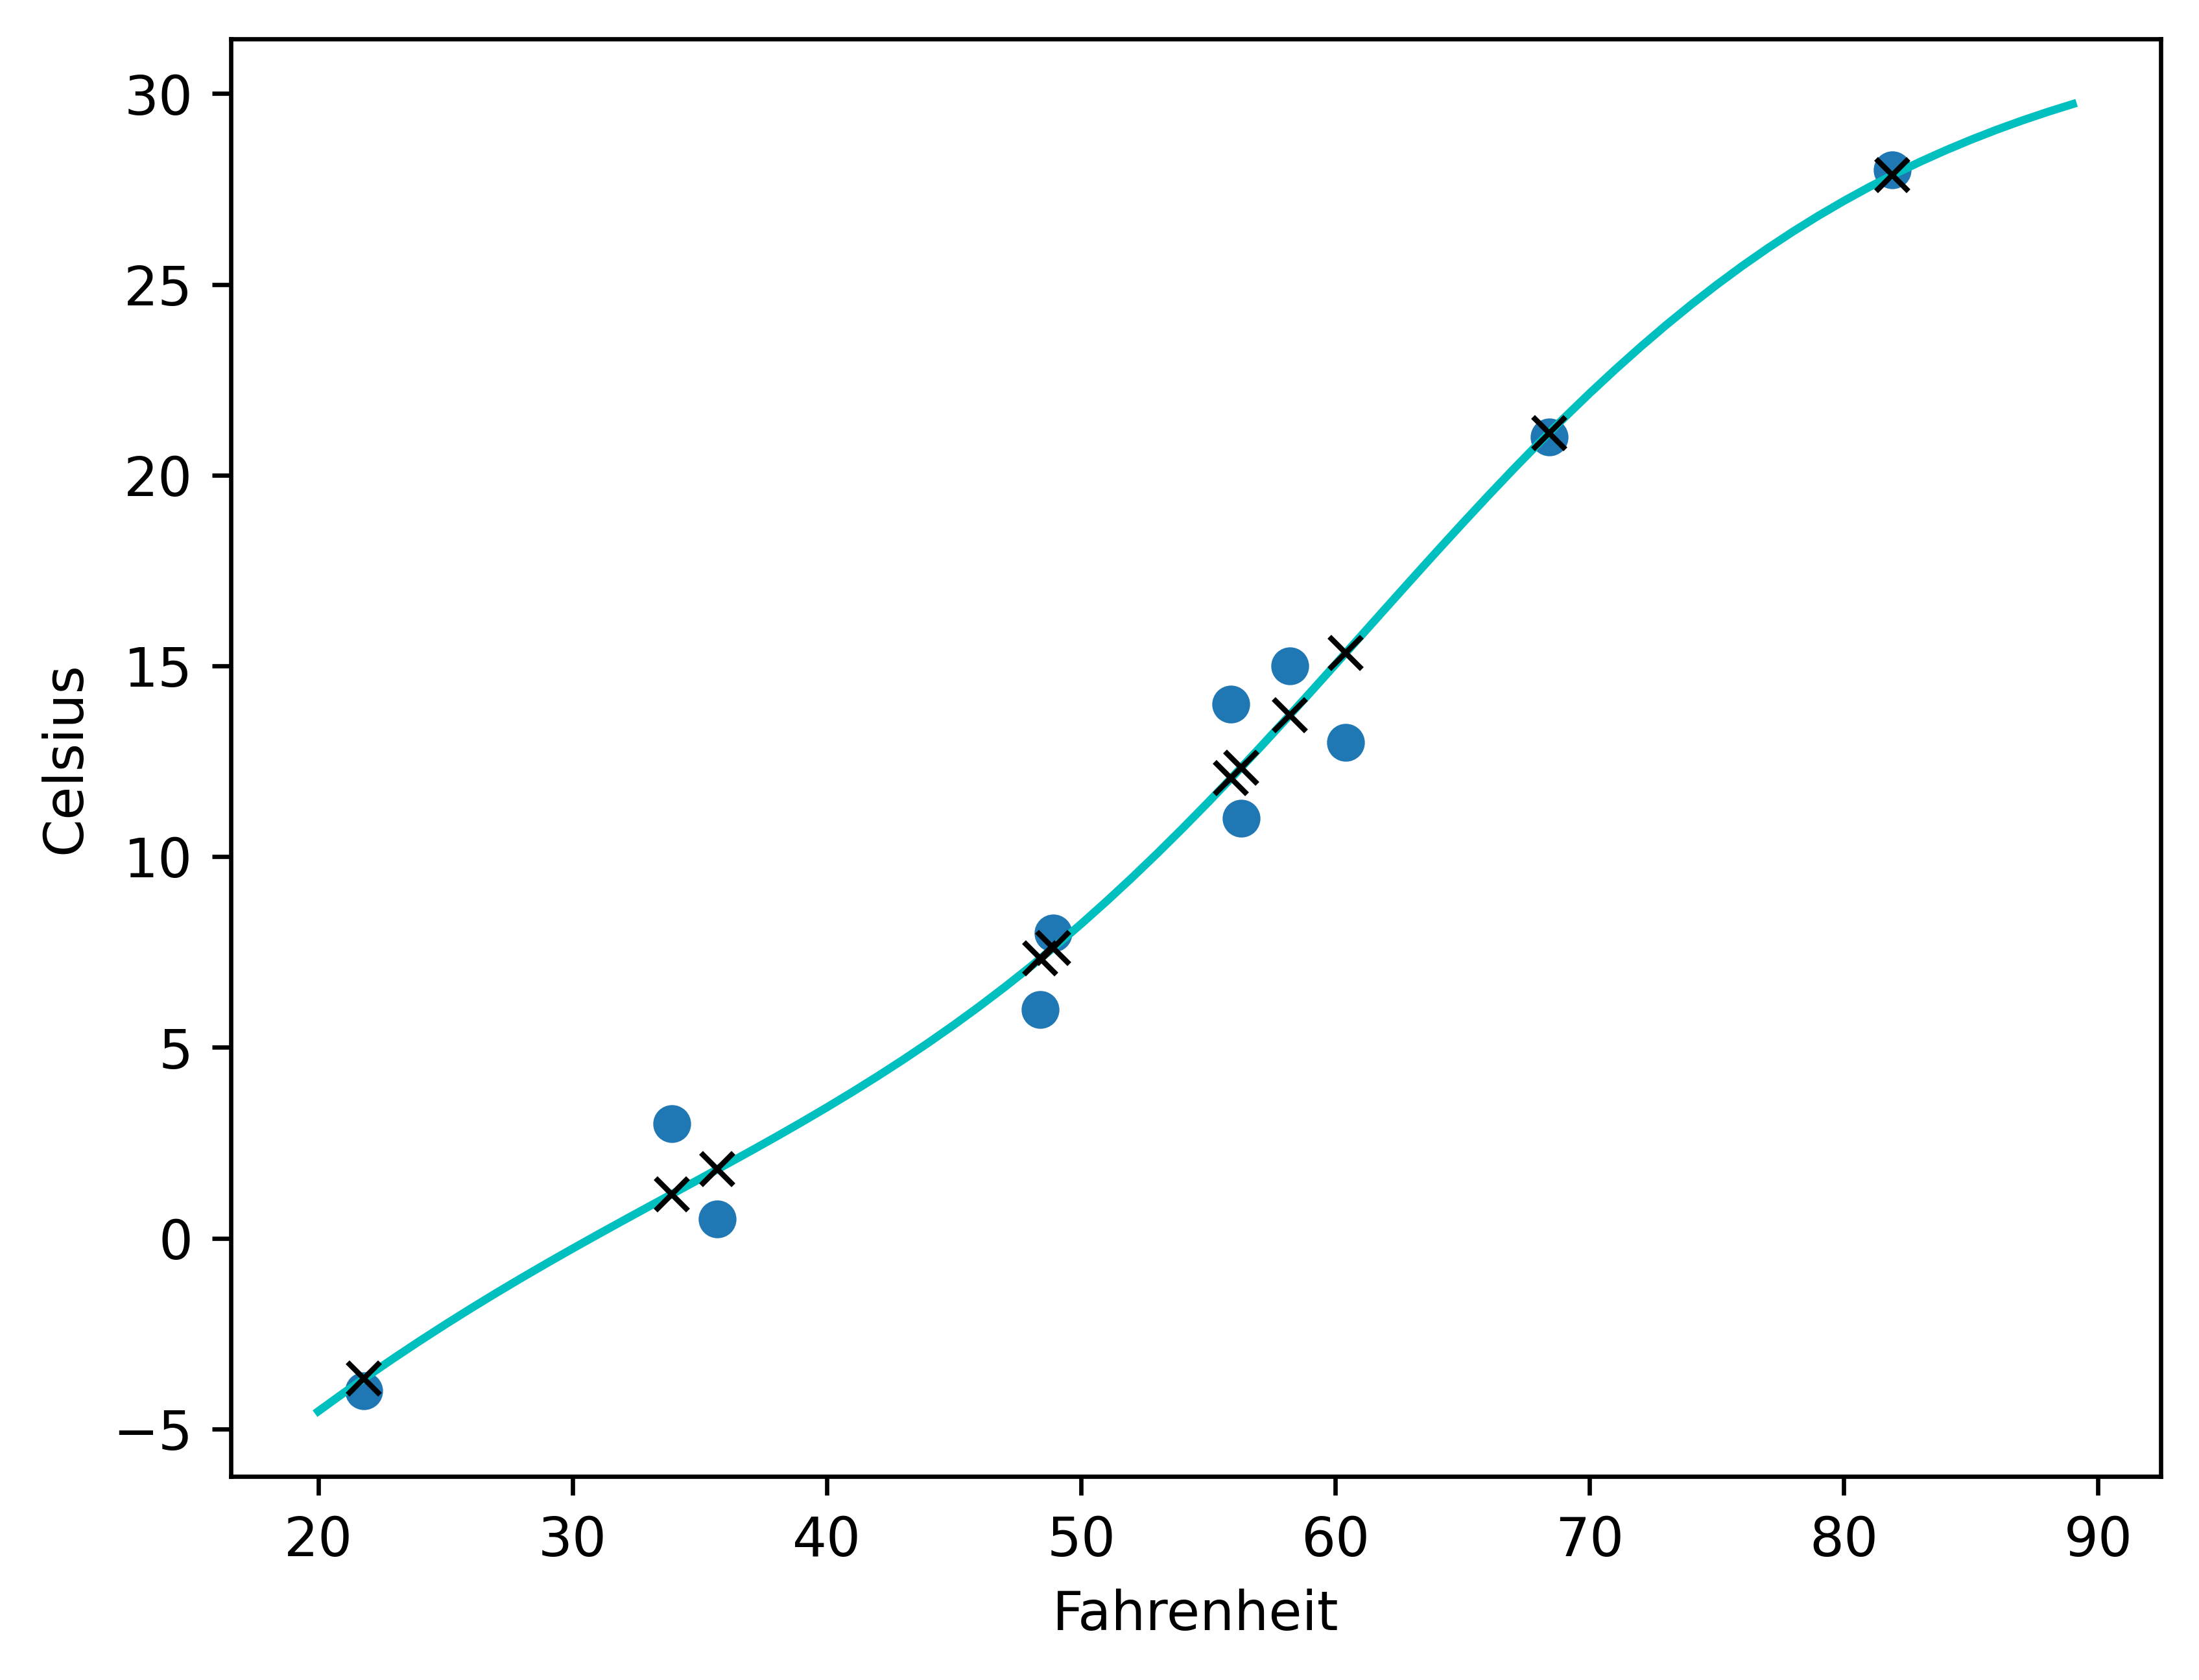

In [132]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 208.2364, Validation loss 228.8409
Epoch 1000, Training loss 62.3612, Validation loss 12.9819
Epoch 2000, Training loss 39.0322, Validation loss 5.1916
Epoch 3000, Training loss 20.4490, Validation loss 2.3031
Epoch 4000, Training loss 11.4350, Validation loss 2.0452
Epoch 5000, Training loss 7.4649, Validation loss 2.6507


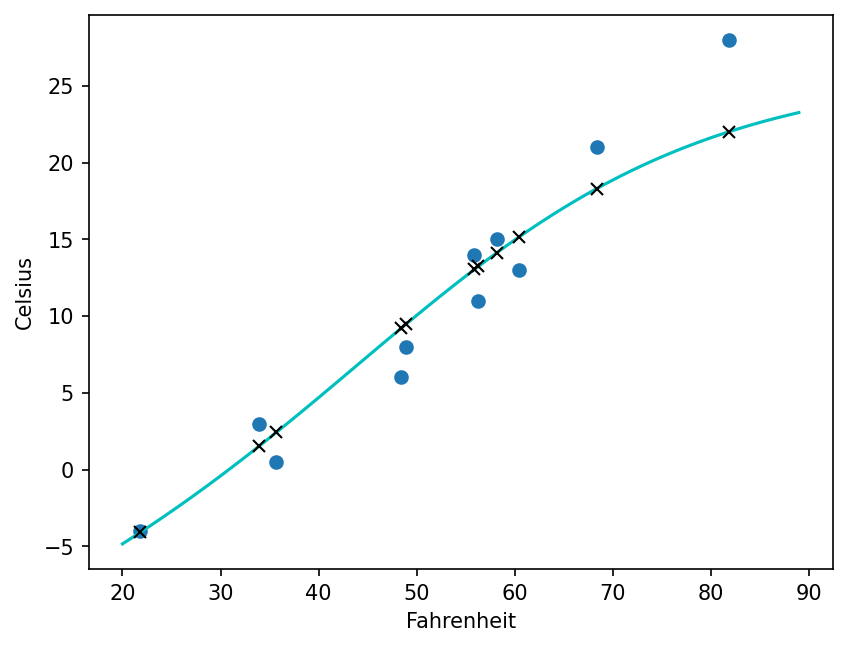

In [133]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
